In [64]:
from sklearn.datasets import make_circles


# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [65]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [66]:
import pandas as pd
circles=pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label":y})
circles.head(10)

X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
5 -0.479646  0.676435      1
6 -0.013648  0.803349      1
7  0.771513  0.147760      1
8 -0.169322 -0.793456      1
9 -0.121486  1.021509      0

In [67]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

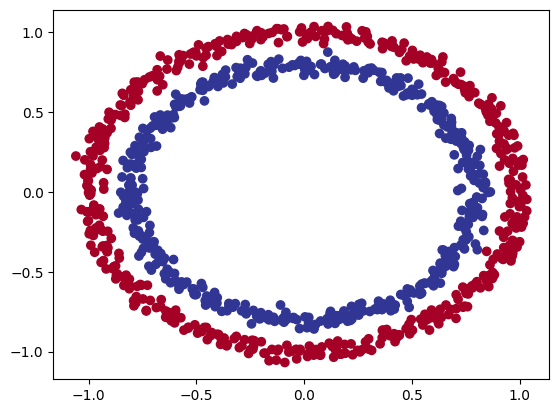

In [68]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu);

In [69]:
X.shape,y.shape

((1000, 2), (1000,))

In [70]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [71]:
import torch
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [72]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
len(x_train),len(x_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [73]:
from torch import nn


In [74]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=5)
    self.layer_2=nn.Linear(in_features=5,out_features=1)
  def forward(self,x):
    return self.layer_2(self.layer_1(x))


In [75]:
model_0=CircleModelV0()
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [76]:
untrained_preds = model_0(x_test)
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [77]:
 loss_fn=nn.BCEWithLogitsLoss()
 optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [78]:
def accuracy_fn(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  acc=(correct/len(y_pred)*100)
  return acc

In [79]:
y_logits=model_0(x_test)[:5]
y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], grad_fn=<SliceBackward0>)

In [80]:
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], grad_fn=<SigmoidBackward0>)

In [81]:
y_preds=torch.round(y_pred_probs)
y_pred_labels=torch.round(torch.sigmoid(model_0(x_test)[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [82]:
torch.manual_seed(42)
epochs=100
for epoch in range(epochs):
    model_0.train()
    y_logits=model_0(x_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss=loss_fn(y_logits,y_train)
    acc=accuracy_fn(y_true=y_train,y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_0.eval()
    with torch.inference_mode():
        test_logist=model_0(x_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logist))
        test_loss=loss_fn(test_logist,y_test)
        test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)
   # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69569, Accuracy: 50.00% | Test loss: 0.69721, Test acc: 50.00%
Epoch: 10 | Loss: 0.69403, Accuracy: 50.00% | Test loss: 0.69615, Test acc: 50.00%
Epoch: 20 | Loss: 0.69343, Accuracy: 46.00% | Test loss: 0.69585, Test acc: 48.50%
Epoch: 30 | Loss: 0.69321, Accuracy: 49.00% | Test loss: 0.69577, Test acc: 47.50%
Epoch: 40 | Loss: 0.69312, Accuracy: 49.50% | Test loss: 0.69573, Test acc: 46.50%
Epoch: 50 | Loss: 0.69308, Accuracy: 50.38% | Test loss: 0.69569, Test acc: 46.50%
Epoch: 60 | Loss: 0.69306, Accuracy: 50.50% | Test loss: 0.69564, Test acc: 46.50%
Epoch: 70 | Loss: 0.69305, Accuracy: 50.50% | Test loss: 0.69559, Test acc: 46.50%
Epoch: 80 | Loss: 0.69304, Accuracy: 50.75% | Test loss: 0.69553, Test acc: 46.50%
Epoch: 90 | Loss: 0.69303, Accuracy: 50.38% | Test loss: 0.69547, Test acc: 46.50%


In [83]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


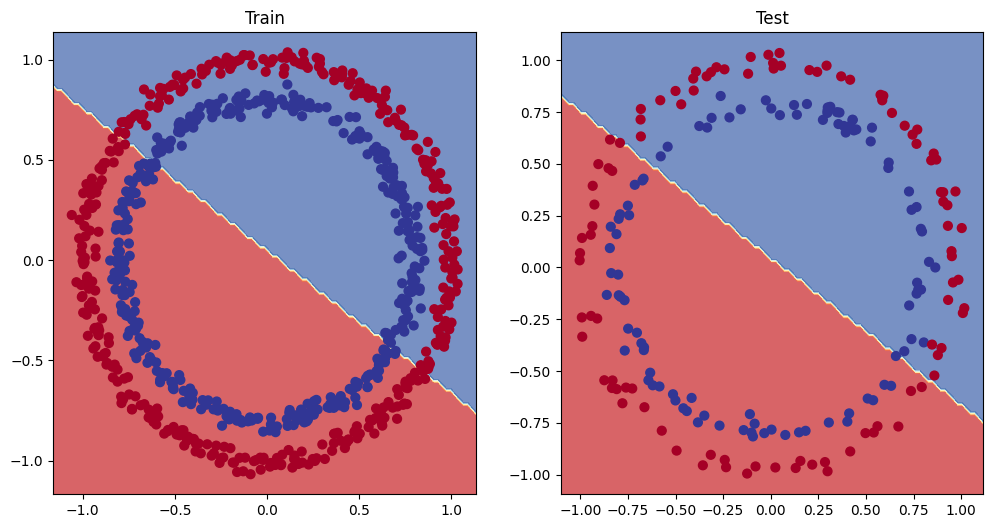

In [84]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)

In [85]:
class CircleModelV1(nn.Module):
  def __init__(self):
      super().__init__()
      self.layer_1=nn.Linear(in_features=2,out_features=10)
      self.layer_2=nn.Linear(in_features=10,out_features=10)
      self.layer_3=nn.Linear(in_features=10,out_features=1)
  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))


In [86]:
model_1=CircleModelV1()
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [87]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model_1.parameters(),lr=0.1)

In [88]:
torch.manual_seed(42)
epochs=1000
for epoch in range(epochs):
  model_1.train()
  y_logists=model_1(x_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))
  loss=loss_fn(y_logists,y_train)
  acc=accuracy_fn(y_true=y_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  model_1.eval()
  with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
  if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69396, Accuracy: 50.50% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.50% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 50.50% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 50.50% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 50.50% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 50.50% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 50.50% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 50.50% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 50.50% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 50.50% | Test loss: 0.69468, Test acc: 46.00%


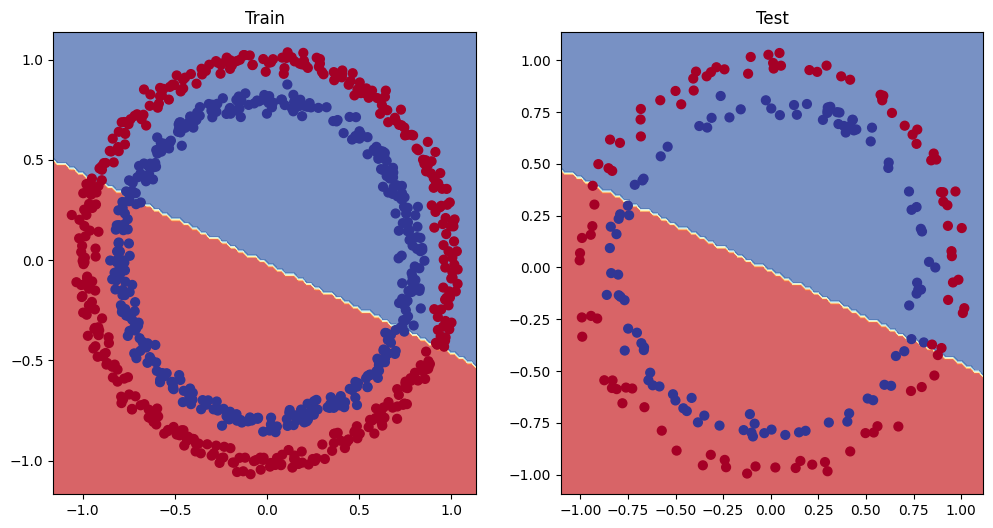

In [89]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, x_test, y_test)

In [90]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [91]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


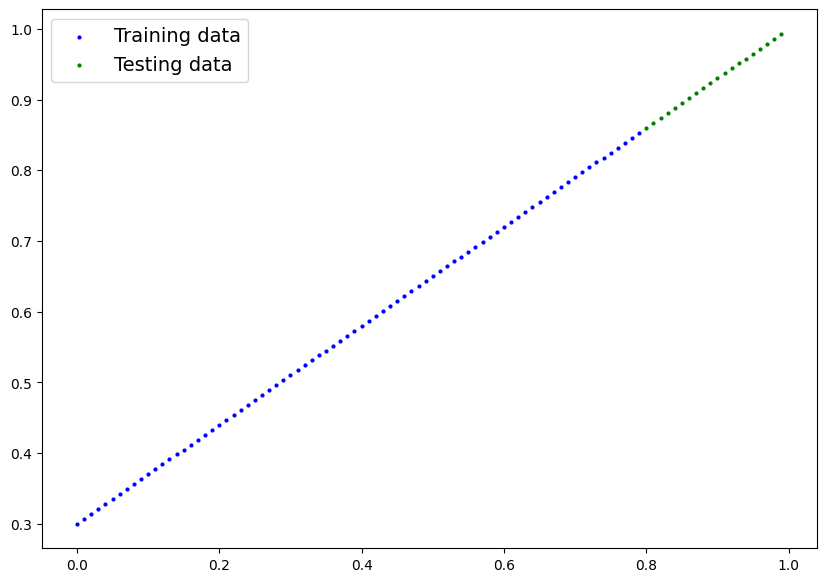

In [92]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [93]:
model_2=nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [94]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [95]:
torch.manual_seed(42)
epochs=1000
for epoch in range(epochs):
  model_2.train()
  y_pred=model_2(X_train_regression)
  loss=loss_fn(y_pred,y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_2.eval()
  with torch.inference_mode():
    test_pred=model_2(X_test_regression)
    test_loss=loss_fn(test_pred,y_test_regression)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test loss: 0.54143
Epoch: 100 | Loss: 0.09309 | Test loss: 0.02901
Epoch: 200 | Loss: 0.07376 | Test loss: 0.02850
Epoch: 300 | Loss: 0.06745 | Test loss: 0.00615
Epoch: 400 | Loss: 0.06107 | Test loss: 0.02004
Epoch: 500 | Loss: 0.05698 | Test loss: 0.01061
Epoch: 600 | Loss: 0.04857 | Test loss: 0.01326
Epoch: 700 | Loss: 0.06109 | Test loss: 0.02127
Epoch: 800 | Loss: 0.05600 | Test loss: 0.01425
Epoch: 900 | Loss: 0.05571 | Test loss: 0.00603


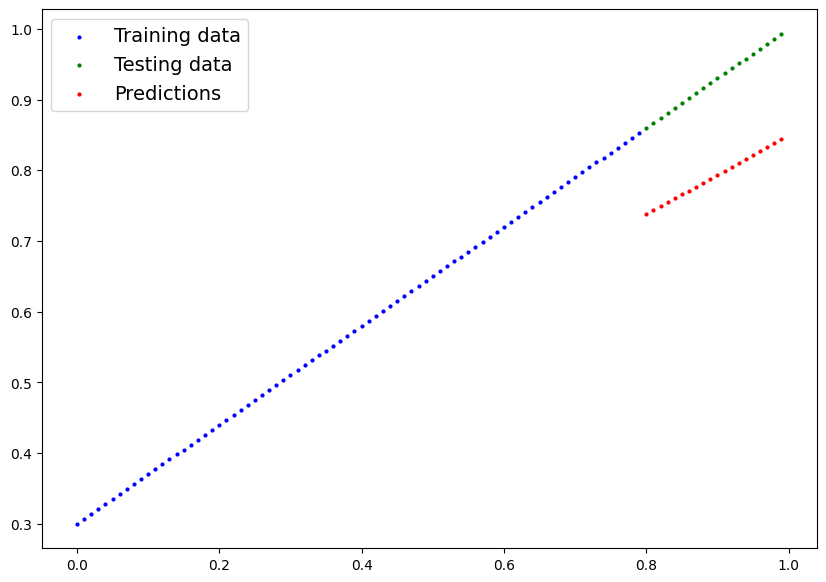

In [96]:
model_2.eval()
with torch.inference_mode():
  y_preds=model_2(X_test_regression)
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                  predictions=y_preds);




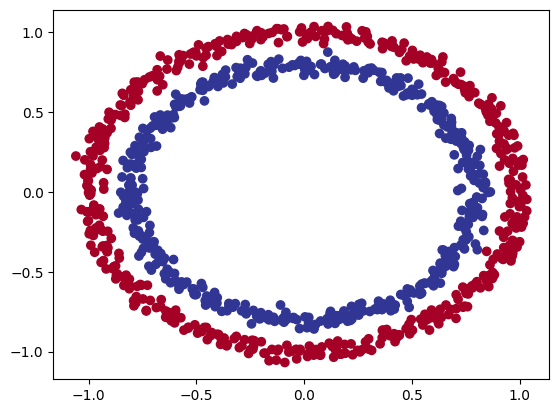

In [97]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
n_samples=1000
x,y=make_circles(n_samples=1000,noise=0.03,random_state=42)
plt.scatter(x[:,0],x[:,1],c=y,cmap=plt.cm.RdYlBu);

In [98]:
import torch
from sklearn.model_selection import train_test_split
x=torch.from_numpy(x).type(torch.float)
y=torch.from_numpy(y).type(torch.float)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
x_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [99]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=10)
    self.layer_2=nn.Linear(in_features=10,out_features=10)
    self.layer_3=nn.Linear(in_features=10,out_features=1)
  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))



In [100]:
model_3=CircleModelV2()
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [101]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model_3.parameters(),lr=0.1)

In [102]:
torch.manual_seed(42)
epochs=1000
for epoch in range(epochs):
  model_3.train()
  y_logits=model_3(x_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))
  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_3.eval()
  with torch.inference_mode():
    test_logits=model_3(x_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test Loss: 0.69261, Test Accuracy: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test Loss: 0.69379, Test Accuracy: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test Loss: 0.69437, Test Accuracy: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test Loss: 0.69458, Test Accuracy: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test Loss: 0.69465, Test Accuracy: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69467, Test Accuracy: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%


In [103]:
model_3.eval()
with torch.inference_mode():
  y_pred=torch.round(torch.sigmoid(model_3(x_test))).squeeze()
y_pred[:10],y[:10]

(tensor([1., 1., 0., 1., 0., 0., 1., 1., 0., 1.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

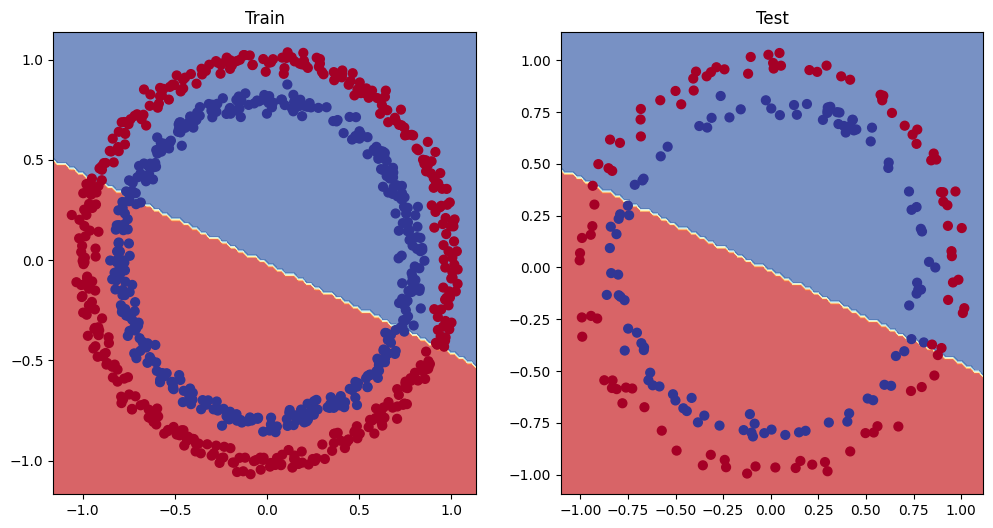

In [104]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, x_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, x_test, y_test) # model_3 = has non-linearity

In [105]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

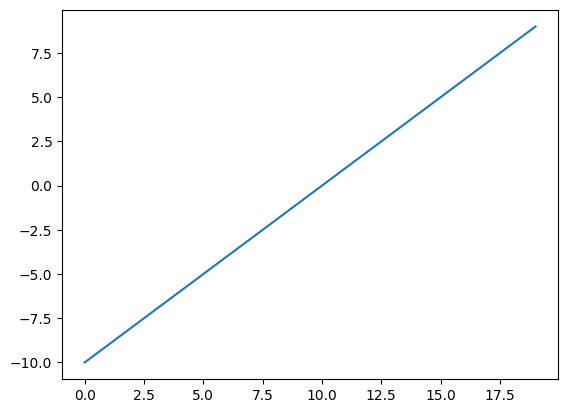

In [106]:
plt.plot(A);

In [107]:
def relu(x):
  return torch.maximum(torch.tensor(0),x)
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

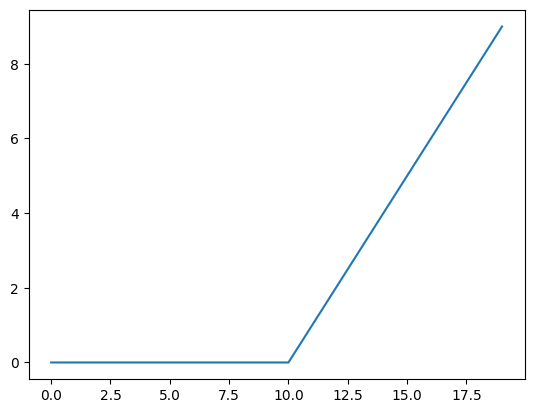

In [108]:
plt.plot(relu(A));

In [109]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

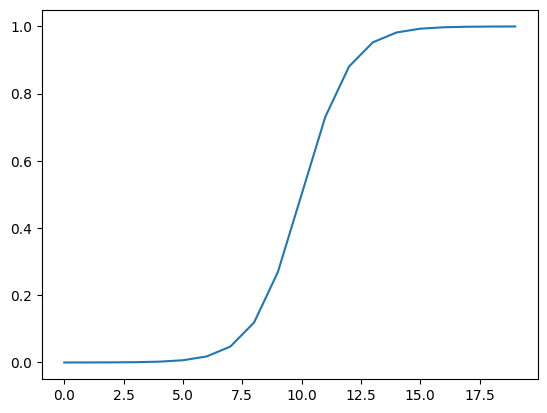

In [110]:
plt.plot(sigmoid(A));

multi class classification

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


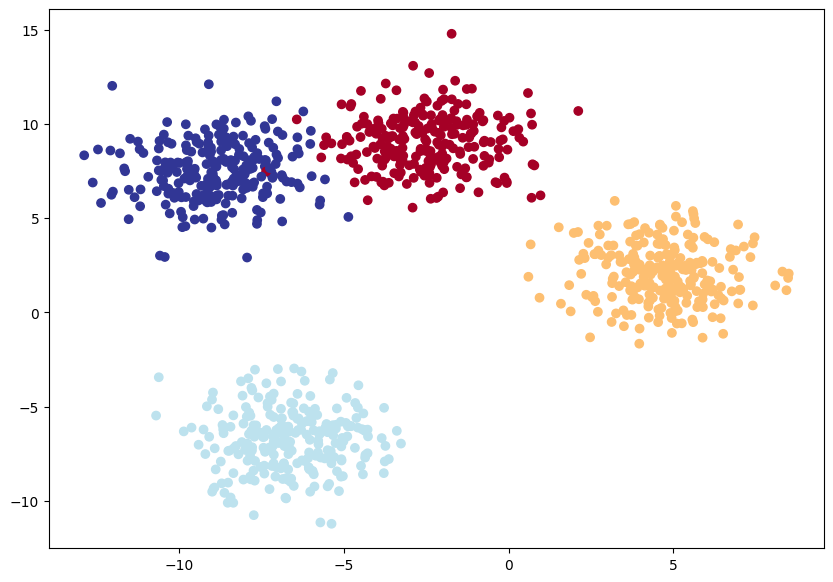

In [111]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
num_class=4
num_feature=2
random_seed=42
x_blob,y_blob=make_blobs(n_samples=1000,n_features=num_feature,centers=num_class,cluster_std=1.5,random_state=random_seed)
x_blob=torch.from_numpy(x_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)
print(x_blob[:5],y_blob[:5])
x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob,
    y_blob,
    test_size=0.2,
    random_state=random_seed
)
plt.figure(figsize=(10,7))
plt.scatter(x_blob[:,0],x_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

In [112]:
from torch import nn
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack=nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=output_features)

    )
  def forward(self,x):
    return self.linear_layer_stack(x)


In [113]:
model_4=BlobModel(input_features=num_feature,output_features=num_class)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [114]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model_4.parameters(),lr=0.1)

In [115]:
model_4(x_blob_train)[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [116]:
model_4(x_blob_train)[0].shape,num_class

(torch.Size([4]), 4)

In [117]:
y_logits=model_4(x_blob_test)
y_pred_prop=torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([1., 1., 0., 1., 0.])


In [118]:
torch.sum(y_pred_prop[0])

tensor(1., grad_fn=<SumBackward0>)

In [119]:
print(y_pred_prop[0])
print(torch.argmax(y_pred_prop[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


In [120]:
import torch # Added explicit import
torch.manual_seed(42)
epochs=100
for epoch in range(epochs):
  model_4.train()
  y_logits=model_4(x_blob_train)
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
  loss=loss_fn(y_logits,y_blob_train)
  acc=accuracy_fn(y_true=y_blob_train,y_pred=y_pred)
  optimizer.zero_grad()

  loss.backward()
  optimizer.step()
  model_4.eval()
  with torch.inference_mode():
    test_logits=model_4(x_blob_test)
    test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss=loss_fn(test_logits,y_blob_test)
    test_acc=accuracy_fn(y_true=y_blob_test,y_pred=test_pred)
  if epoch % 10 ==0 :
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.04324, Accuracy: 65.50% | Test loss: 0.57861, Test acc: 95.50%
Epoch: 10 | Loss: 0.14398, Accuracy: 99.12% | Test loss: 0.13037, Test acc: 99.00%
Epoch: 20 | Loss: 0.08062, Accuracy: 99.12% | Test loss: 0.07216, Test acc: 99.50%
Epoch: 30 | Loss: 0.05924, Accuracy: 99.12% | Test loss: 0.05133, Test acc: 99.50%
Epoch: 40 | Loss: 0.04892, Accuracy: 99.00% | Test loss: 0.04098, Test acc: 99.50%
Epoch: 50 | Loss: 0.04295, Accuracy: 99.00% | Test loss: 0.03486, Test acc: 99.50%
Epoch: 60 | Loss: 0.03910, Accuracy: 99.00% | Test loss: 0.03083, Test acc: 99.50%
Epoch: 70 | Loss: 0.03643, Accuracy: 99.00% | Test loss: 0.02799, Test acc: 99.50%
Epoch: 80 | Loss: 0.03448, Accuracy: 99.00% | Test loss: 0.02587, Test acc: 99.50%
Epoch: 90 | Loss: 0.03300, Accuracy: 99.12% | Test loss: 0.02423, Test acc: 99.50%


In [122]:
model_4.eval()
with torch.inference_mode():
  y_pred=torch.softmax(model_4(x_blob_test), dim=1)
y_logits[:10]

tensor([[  3.4936,  10.6391, -13.8460,  -9.9603],
        [  7.3736,  -1.4318,  -9.4436,   0.7642],
        [ -6.6095, -17.7317,  26.3918,  16.8846],
        [ -3.0567, -11.8081,  15.7462,  11.1566],
        [  5.6365,  -3.4246,  -5.0196,   2.7374],
        [  6.4041,   4.2334, -12.8337,  -4.3417],
        [  7.5781,  -4.3287,  -7.2572,   3.3999],
        [  2.8575,   8.2037, -10.7513,  -7.6755],
        [  3.9875, -11.7893,   4.7763,  10.5389],
        [  6.5579,  -3.7713,  -6.1526,   2.9764]], grad_fn=<SliceBackward0>)

In [129]:
y_pred_probs=torch.softmax(y_logits,dim=1)
y_preds=y_pred_probs.argmax(dim=1)
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")


Predictions: tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])


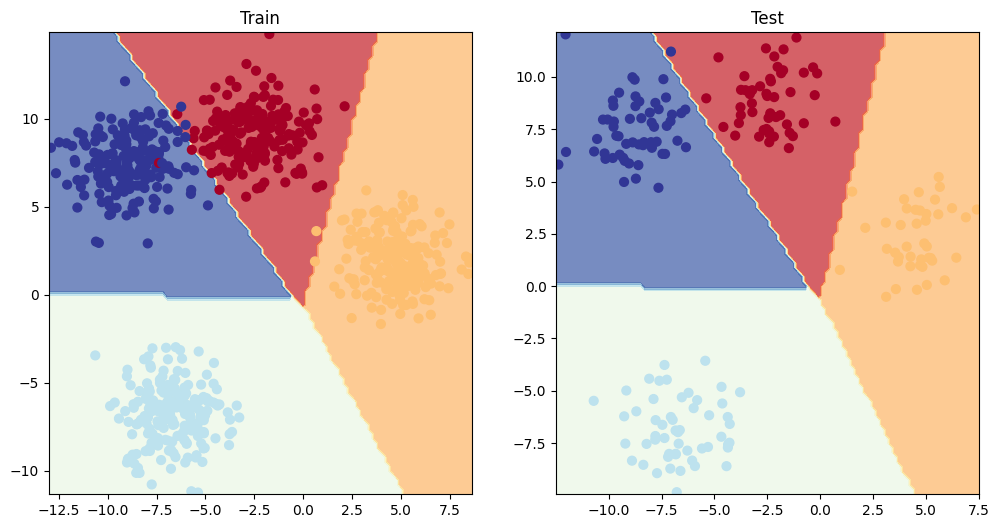

In [130]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, x_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, x_blob_test, y_blob_test)